In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from pathlib import Path
import matplotlib.pyplot as plt
import shutil
import random

In [33]:

dataset_path = Path("./garbage-classification")
images_dir = Path("./garbage-classification")  # The path where the dataset is unzipped

#  Print categories for inspection
print("Image Directory:", images_dir)
print("Category Name:", os.listdir(images_dir))
print("Number of Categories:", len(os.listdir(images_dir)))


Image Directory: garbage-classification
Category Name: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Number of Categories: 10


In [32]:
# Original dataset path (each subfolder is a category)
source_dir = Path("garbage-classification")
target_base = Path("garbage-split")

# Proportion settings
train_ratio = 0.7 # train set
val_ratio = 0.2   # validation set
test_ratio = 0.1  # test set

# Make sure the target path exists
for split in ["train", "val", "test"]:
    (target_base / split).mkdir(parents=True, exist_ok=True)

# Loop through each category folder
for class_name in os.listdir(source_dir):
    class_path = source_dir / class_name
    if not class_path.is_dir():
        continue

    # Get all image paths for the current category
    images = list(class_path.glob("*"))
    random.shuffle(images)

    total = len(images)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    splits = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:]
    }

   ##  Copy to new location
   # for split_name, file_list in splits.items():
   #    split_class_dir = target_base / split_name / class_name
   #     split_class_dir.mkdir(parents=True, exist_ok=True)

   #     for img_path in file_list:
   #         shutil.copy(img_path, split_class_dir / img_path.name)

print("The data set is automatically divided!")

The data set is automatically divided!


In [ ]:
#  Setting image processing and training parameters
img_size = 128 #The image size of the dataset is unified
batch_size = 64
epochs = 500
AUTOTUNE = tf.data.AUTOTUNE #Optimize data pipeline (increase graphics card training speed)

# Path
base_dir = Path("garbage-split")
train_dir = base_dir / "train"
val_dir   = base_dir / "val"
test_dir  = base_dir / "test"

# Load data function
def load_dataset(directory, shuffle=True):
    return tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        label_mode='categorical',
        shuffle=shuffle
    )

# Load train / val / test
train_ds = load_dataset(train_dir, shuffle=True)
val_ds   = load_dataset(val_dir, shuffle=False)
test_ds  = load_dataset(test_dir, shuffle=False)

# Get the number of labels and categories
class_names = train_ds.class_names
num_classes = len(class_names)

# Data Normalization
def preprocess(image, label):
    image = tf.image.resize(image, [img_size, img_size])  # Ensure uniform size

    # Image preprocessing
    image = tf.image.random_flip_left_right(image)         # Random left-right flip
    image = tf.image.random_brightness(image, max_delta=0.2) # Random Brightness
    image = tf.image.random_contrast(image, 0.8, 1.2)        # Random Contrast
    image = tf.image.random_saturation(image, 0.8, 1.2)      # Random Saturation
    image = tf.image.random_hue(image, 0.05)                 # Random Hues
    image = tf.cast(image, tf.float32) / 255.0               # Normalization
    return image, label


# Automatic prefetching + caching (speeds up training)
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)

Found 13824 files belonging to 10 classes.
Found 3948 files belonging to 10 classes.
Found 1987 files belonging to 10 classes.


In [5]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


In [31]:
train_sample_count = tf.data.experimental.cardinality(train_ds).numpy() * batch_size
val_sample_count   = tf.data.experimental.cardinality(val_ds).numpy() * batch_size
test_sample_count  = tf.data.experimental.cardinality(test_ds).numpy() * batch_size

print("Number of training classes:", num_classes)
print("Class names:", class_names)
print("Number of training samples:", train_sample_count)
print("Number of validation samples:", val_sample_count)
print("Number of test samples:", test_sample_count)

Number of training classes: 10
Class names: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Number of training samples: 13824
Number of validation samples: 3968
Number of test samples: 2048


In [7]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3),kernel_regularizer=l2(0.0001)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu',kernel_regularizer=l2(0.0001)),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu',kernel_regularizer=l2(0.0001)),
    
    # Flatten(), # Not as good as GlobalAveragePooling2D()
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax', dtype='float32')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),# Learning rate in here
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 global_average_pooling2d (G  (None, 128)              0

In [ ]:
print("TensorFlow version:", tf.__version__) # Confirm that the graphics card is available
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.10.0
Num GPUs Available: 1


In [ ]:
# Set training callback (monitor model training status, and when the optimal point is found, 
# continue training with patience = 10 epochs, and stop training if the subsequent point is not the optimal point)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

#  Start training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/500
216/216 [==============================] - 34s 58ms/step - loss: 2.0606 - accuracy: 0.3116 - val_loss: 1.8844 - val_accuracy: 0.3756
Epoch 2/500
216/216 [==============================] - 9s 41ms/step - loss: 1.8568 - accuracy: 0.3765 - val_loss: 1.7542 - val_accuracy: 0.4119
Epoch 3/500
216/216 [==============================] - 9s 41ms/step - loss: 1.7721 - accuracy: 0.4043 - val_loss: 1.6894 - val_accuracy: 0.4162
Epoch 4/500
216/216 [==============================] - 9s 41ms/step - loss: 1.7012 - accuracy: 0.4290 - val_loss: 1.7391 - val_accuracy: 0.4134
Epoch 5/500
216/216 [==============================] - 9s 40ms/step - loss: 1.6515 - accuracy: 0.4425 - val_loss: 1.5761 - val_accuracy: 0.4585
Epoch 6/500
216/216 [==============================] - 9s 41ms/step - loss: 1.6042 - accuracy: 0.4564 - val_loss: 1.5430 - val_accuracy: 0.4790
Epoch 7/500
216/216 [==============================] - 9s 41ms/step - loss: 1.5801 - accuracy: 0.4656 - val_loss: 1.4952 - val_accuracy

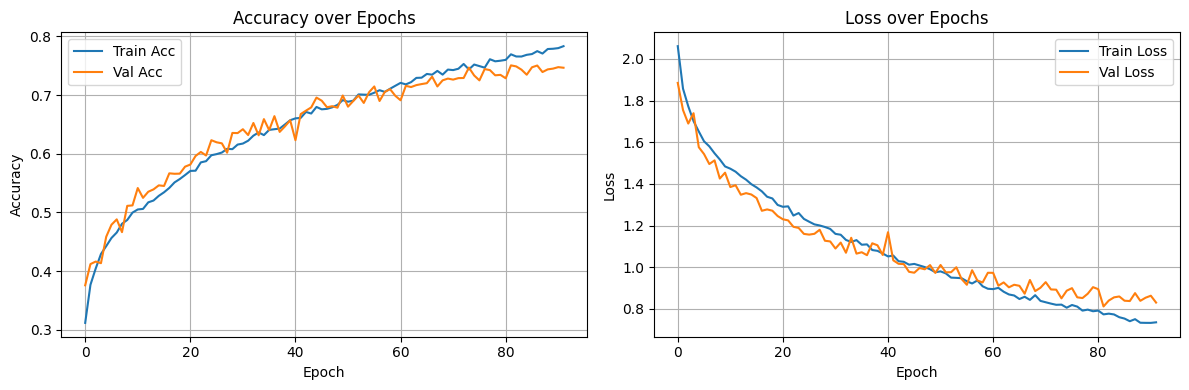

In [ ]:
# Visualizing the training process
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
# Evaluate the model using the test set
test_ds  = load_dataset(test_dir, shuffle=False)
test_ds  = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
loss, acc = model.evaluate(test_ds)
print(f"Test set accuracy: {acc*100:.2f}%")
print(f"Test set loss: {loss*100:.2f}%")

Found 1987 files belonging to 10 classes.
32/32 [==============================] - 2s 50ms/step - loss: 0.7998 - accuracy: 0.7609
Test set accuracy: 76.09%
Test set loss: 79.98%


Report (Classification Report):
              precision    recall  f1-score   support

     battery       0.69      0.83      0.75        96
  biological       0.82      0.78      0.80       101
   cardboard       0.74      0.84      0.78       183
     clothes       0.82      0.95      0.88       534
       glass       0.78      0.73      0.75       307
       metal       0.59      0.50      0.54       102
       paper       0.76      0.60      0.67       169
     plastic       0.64      0.64      0.64       200
       shoes       0.75      0.62      0.68       199
       trash       0.68      0.53      0.60        96

    accuracy                           0.75      1987
   macro avg       0.73      0.70      0.71      1987
weighted avg       0.75      0.75      0.75      1987



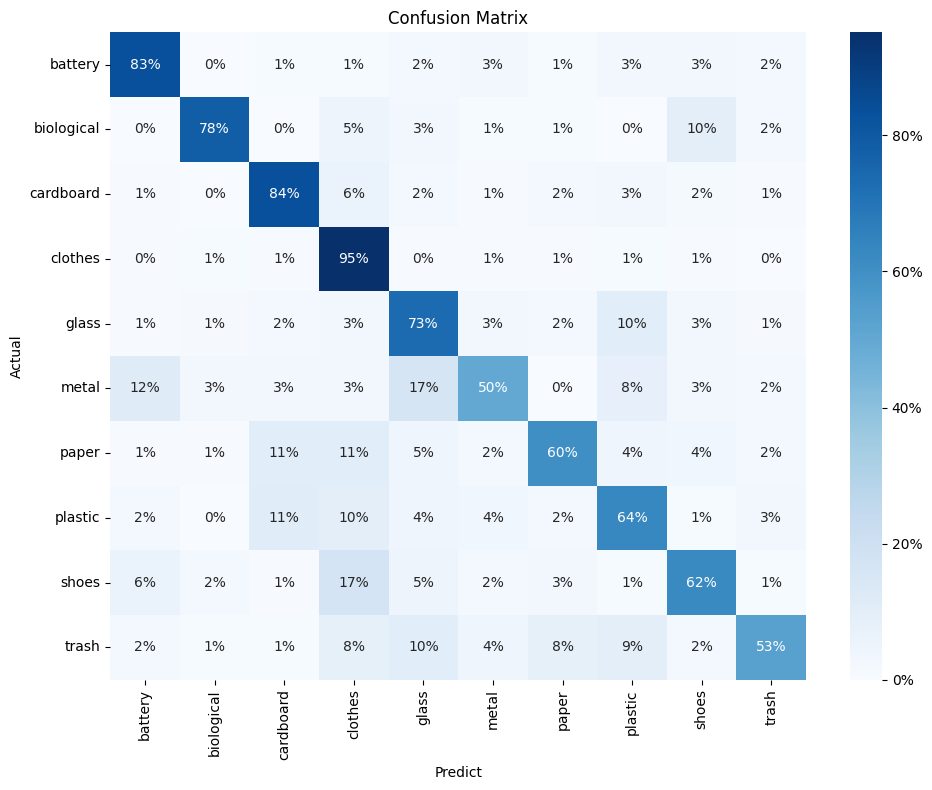

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Extracting true labels and images
y_true = []
y_pred = []

for images, labels in test_ds:  # Traverse test_ds, each batch
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))            # Model prediction results
    y_true.extend(np.argmax(labels.numpy(), axis=1))   # The original one-hot labels are converted to indices

# Convert to numpy array
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification Report
print("Report (Classification Report):")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Row Normalization

plt.figure(figsize=(10, 8))
ax=sns.heatmap(cm_normalized, annot=True, fmt='.0%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

# Set the colorbar to display as percentage
colorbar = ax.collections[0].colorbar
colorbar.ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.title("Confusion Matrix")
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()
